## Задание 8.
#### Исполнитель: Гребенькова Ольга
Визуализировать MDL, аналогично слайду 7 из презентации, в зависимости от размера скрытого слоя однослойной нейросети нейронной сети. Модель: однослойная нейросеть. Выборка: одна из стандартных датасетов sklearn. Априорное распределение параметров: нормальное распределение со скалярным параметром дисперсии дисперсией (N(0, sigma^2 * I)). Оптимизацию sigma провести итеративным методом с использованием аппрксимации Лапласа.



### Импортируем все нужные библиотеки

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from sklearn import datasets
import tqdm
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn.init as init
import math

In [44]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

### Инициализация параметров

In [62]:
init_log_sigma = -2.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 30 #количество эпох
hidden_num = 50 # количество нейронов на скрытом слое, в итоге просто настроила руками этот параметр

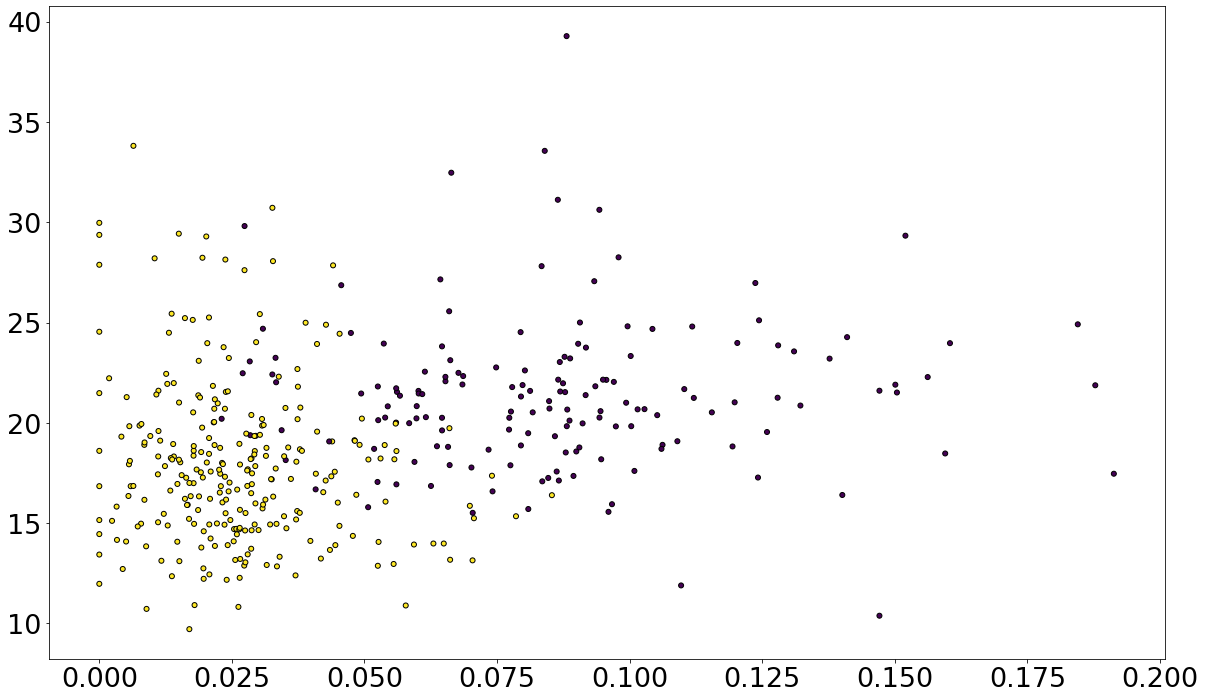

In [63]:
# загрузка данных
data = datasets.load_breast_cancer()

# Store the feature data
X = data.data
# store the target data
y = data.target
# split the data using Scikit-Learn's train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

plt.scatter(X_train[:, 7], X_train[:, 1], marker='o', c=y_train,
            s=25, edgecolor='k')

plt.show()


### Функция обучения. К обычному лоссу добавляем лосс, отвечающий обновлению распределения

In [64]:
def train(net, loss_fn, optimizer):
    losses = []
    x = t.FloatTensor(X_train).to(device)
    y = t.Tensor(y_train).to(device).to(t.long)
    optimizer.zero_grad()  
    loss = 0                
    out = net(x)
    loss = loss + loss_fn(out, y)
    log_likelihood = log_gaussian(y.unsqueeze(1), F.softmax(out), prior_sigma).sum()
    log_qw, log_pw = net.approx()
    loss += ((log_qw - log_pw) - log_likelihood).sum() / len(y_train)
    loss.backward()       
    clip_grad_value_(net.parameters(), 1.0) # для стабильности градиента. С этим можно играться
    optimizer.step()
    

In [65]:
def log_gaussian(x, mu, sigma):
    eps = t.distributions.Normal(mu, sigma)
    return eps.log_prob(x)

def log_gaussian_logsigma(x, mu, log_sigma):
    eps = t.distributions.Normal(mu, MIN_SIGMA+t.exp(log_sigma))
    return eps.log_prob(x)

### Код для вариационной нейронной сети. В общем случае можно делать много слоев, мы же будеи использовать один. Для каждого слоя считаем аппроксимацию по следующей формуле:
$ \log(q(\mathbf{w}| \theta))  - \log P(D | \mathbf{w}) - \log P(\mathbf{w})$


Вот статья, где похожие вещи подробно расписывают
https://arxiv.org/pdf/1505.05424v2.pdf

In [66]:
MIN_SIGMA = 1e-5 # чтобы было все хорошо в распределении
    
class VarLayer(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   prior_sigma = 1.0, init_log_sigma=-3.0, act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = nn.Parameter(t.randn(in_, out_)) # параметры средних
        t.nn.init.xavier_uniform_(self.mean) 
        self.log_sigma = nn.Parameter(t.ones(in_, out_)*init_log_sigma) # логарифм дисперсии
        self.mean_b = nn.Parameter(t.randn(out_)) # то же самое для свободного коэффициента
        self.log_sigma_b = nn.Parameter(t.ones(out_) * init_log_sigma)
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        self.prior_sigma = prior_sigma
        
    def forward(self,x):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean, MIN_SIGMA+t.exp(self.log_sigma))
            self.eps_b = t.distributions.Normal(self.mean_b, MIN_SIGMA+t.exp(self.log_sigma_b))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean 
            b = self.mean_b   
        # функция активации         
        return self.act(t.matmul(x, w)+b)

    def approx(self):
        log_pw, log_qw = 0, 0
        self.eps_w = t.distributions.Normal(self.mean, MIN_SIGMA+t.exp(self.log_sigma))
        self.eps_b = t.distributions.Normal(self.mean_b, MIN_SIGMA+t.exp(self.log_sigma_b))
        
        w = self.eps_w.rsample()
        b = self.eps_b.rsample()
             
         # first weight prior
        log_pw += log_gaussian(w, 0., prior_sigma).sum()
        log_pw += log_gaussian(b, 0., prior_sigma).sum()

        # then approximation
        log_qw += log_gaussian_logsigma(w, self.mean, self.log_sigma * 2).sum()
        log_qw += log_gaussian_logsigma(b, self.mean_b, self.log_sigma_b * 2).sum()
    
        return log_pw, log_qw
    
    
#Обертка для нескольких вариационных слоев
class VarNet(nn.Sequential):    
    def approx(self):
        log_pw, log_qw = 0, 0
        for l in self:
            log_pw_t, log_qw_t =l.approx()
            log_pw += log_pw_t
            log_qw += log_qw_t
        return log_pw, log_qw
    
    def forward(self, x):
        for l in self:
            x = l(x)
        return x
    

In [67]:
def test_acc(net): # точность классификации
    acc = []    
    net.eval() 
    x = t.FloatTensor(X_test).to(device)
    y = t.Tensor(y_test).to(device).to(t.long)
    out = net(x)    
    correct = out.argmax(1).eq(y).sum().cpu().numpy()
    acc = (correct / len(y_test))

    return acc

In [68]:
#Сеть 5 скрытых нейронов
net = VarNet(VarLayer(30,  5, 
                                prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                     VarLayer(5, 2, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                              act=lambda x:x))
net = net.to(device)
optim = t.optim.Adam(net.parameters(), lr=5e-4)
loss_fn = nn.CrossEntropyLoss().to(device)            
for e in range(epoch_num):     
    train(net, loss_fn, optim)
    print("Эпоха {}.Точность модели".format(e), test_acc(net))

/home/magistrkoljan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Эпоха 0.Точность модели 0.6223776223776224
Эпоха 1.Точность модели 0.6223776223776224
Эпоха 2.Точность модели 0.6223776223776224
Эпоха 3.Точность модели 0.6223776223776224
Эпоха 4.Точность модели 0.6223776223776224
Эпоха 5.Точность модели 0.6223776223776224
Эпоха 6.Точность модели 0.6223776223776224
Эпоха 7.Точность модели 0.6223776223776224
Эпоха 8.Точность модели 0.6223776223776224
Эпоха 9.Точность модели 0.6223776223776224
Эпоха 10.Точность модели 0.6223776223776224
Эпоха 11.Точность модели 0.6223776223776224
Эпоха 12.Точность модели 0.6223776223776224
Эпоха 13.Точность модели 0.6223776223776224
Эпоха 14.Точность модели 0.6223776223776224
Эпоха 15.Точность модели 0.6223776223776224
Эпоха 16.Точность модели 0.6223776223776224
Эпоха 17.Точность модели 0.6223776223776224
Эпоха 18.Точность модели 0.6223776223776224
Эпоха 19.Точность модели 0.6223776223776224
Эпоха 20.Точность модели 0.6223776223776224
Эпоха 21.Точность модели 0.6223776223776224
Эпоха 22.Точность модели 0.622377622377622

In [69]:
#Сеть 7 скрытых нейронов
net2 = VarNet(VarLayer(30,  7, 
                                prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                     VarLayer(7, 2, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                              act=lambda x:x))
net2 = net2.to(device)
optim = t.optim.Adam(net2.parameters(), lr=5e-4)
loss_fn = nn.CrossEntropyLoss().to(device)            
for e in range(epoch_num):     
    train(net2, loss_fn, optim)
    print("Эпоха {}.Точность модели".format(e), test_acc(net2))

Эпоха 0.Точность модели 0.3776223776223776
Эпоха 1.Точность модели 0.3776223776223776
Эпоха 2.Точность модели 0.3776223776223776
Эпоха 3.Точность модели 0.3776223776223776
Эпоха 4.Точность модели 0.38461538461538464
Эпоха 5.Точность модели 0.3916083916083916
Эпоха 6.Точность модели 0.40559440559440557


/home/magistrkoljan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Эпоха 7.Точность модели 0.40559440559440557
Эпоха 8.Точность модели 0.40559440559440557
Эпоха 9.Точность модели 0.4195804195804196
Эпоха 10.Точность модели 0.4195804195804196
Эпоха 11.Точность модели 0.4965034965034965
Эпоха 12.Точность модели 0.5734265734265734
Эпоха 13.Точность модели 0.6083916083916084
Эпоха 14.Точность модели 0.6293706293706294
Эпоха 15.Точность модели 0.6573426573426573
Эпоха 16.Точность модели 0.6713286713286714
Эпоха 17.Точность модели 0.6853146853146853
Эпоха 18.Точность модели 0.6853146853146853
Эпоха 19.Точность модели 0.6853146853146853
Эпоха 20.Точность модели 0.6783216783216783
Эпоха 21.Точность модели 0.6573426573426573
Эпоха 22.Точность модели 0.6503496503496503
Эпоха 23.Точность модели 0.6363636363636364
Эпоха 24.Точность модели 0.6223776223776224
Эпоха 25.Точность модели 0.6433566433566433
Эпоха 26.Точность модели 0.5944055944055944
Эпоха 27.Точность модели 0.5664335664335665
Эпоха 28.Точность модели 0.5524475524475524
Эпоха 29.Точность модели 0.552447

In [70]:
#Сеть 10 скрытых нейронов
net3 = VarNet(VarLayer(30,  10, 
                                prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                     VarLayer(10, 2, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                              act=lambda x:x))
net3 = net3.to(device)
optim = t.optim.Adam(net3.parameters(), lr=5e-4)
loss_fn = nn.CrossEntropyLoss().to(device)            
for e in range(epoch_num):     
    train(net3, loss_fn, optim)
    print("Эпоха {}.Точность модели".format(e), test_acc(net3))

Эпоха 0.Точность модели 0.5664335664335665
Эпоха 1.Точность модели 0.6013986013986014
Эпоха 2.Точность модели 0.6853146853146853
Эпоха 3.Точность модели 0.7622377622377622
Эпоха 4.Точность модели 0.8391608391608392
Эпоха 5.Точность модели 0.8881118881118881
Эпоха 6.Точность модели 0.8671328671328671
Эпоха 7.Точность модели 0.8461538461538461
Эпоха 8.Точность модели 0.8531468531468531
Эпоха 9.Точность модели 0.8461538461538461
Эпоха 10.Точность модели 0.8601398601398601
Эпоха 11.Точность модели 0.9020979020979021
Эпоха 12.Точность модели 0.8951048951048951
Эпоха 13.Точность модели 0.8951048951048951
Эпоха 14.Точность модели 0.8741258741258742


/home/magistrkoljan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Эпоха 15.Точность модели 0.8811188811188811
Эпоха 16.Точность модели 0.8881118881118881
Эпоха 17.Точность модели 0.8881118881118881
Эпоха 18.Точность модели 0.8881118881118881
Эпоха 19.Точность модели 0.9020979020979021
Эпоха 20.Точность модели 0.8881118881118881
Эпоха 21.Точность модели 0.8951048951048951
Эпоха 22.Точность модели 0.8951048951048951
Эпоха 23.Точность модели 0.8951048951048951
Эпоха 24.Точность модели 0.8951048951048951
Эпоха 25.Точность модели 0.8951048951048951
Эпоха 26.Точность модели 0.8951048951048951
Эпоха 27.Точность модели 0.8951048951048951
Эпоха 28.Точность модели 0.8951048951048951
Эпоха 29.Точность модели 0.9020979020979021


In [71]:
# функция выводит нужные значения для минимальной длины описания без лишних подсчетов градиентов
def find_mdl(net):
    x = t.FloatTensor(X_train).to(device)
    y = t.Tensor(y_train).to(device).to(t.long)
    with t.no_grad():            
        out = net(x)
        log_likelihood = log_gaussian(y.unsqueeze(1), F.softmax(out, dim = 1), prior_sigma).sum()
        log_qw, log_pw = net.approx()
    return log_likelihood.cpu().item(), log_qw.cpu().item(), log_pw.cpu().item()

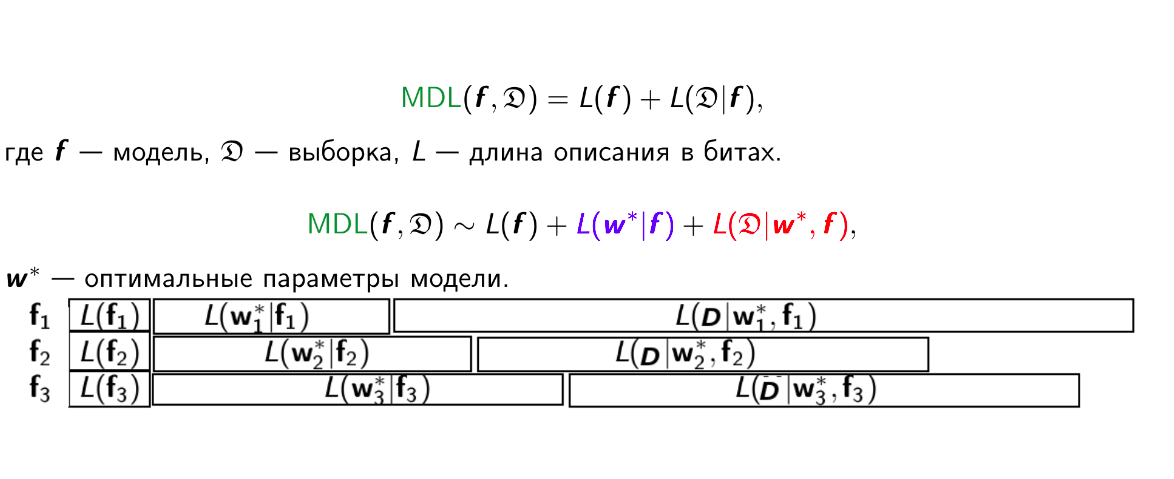

$ l_2 = \log(q(\mathbf{w}| \theta))$

$ l_3 = \log P(D | \mathbf{w}) $

$l_1 =\log P(\mathbf{w})$


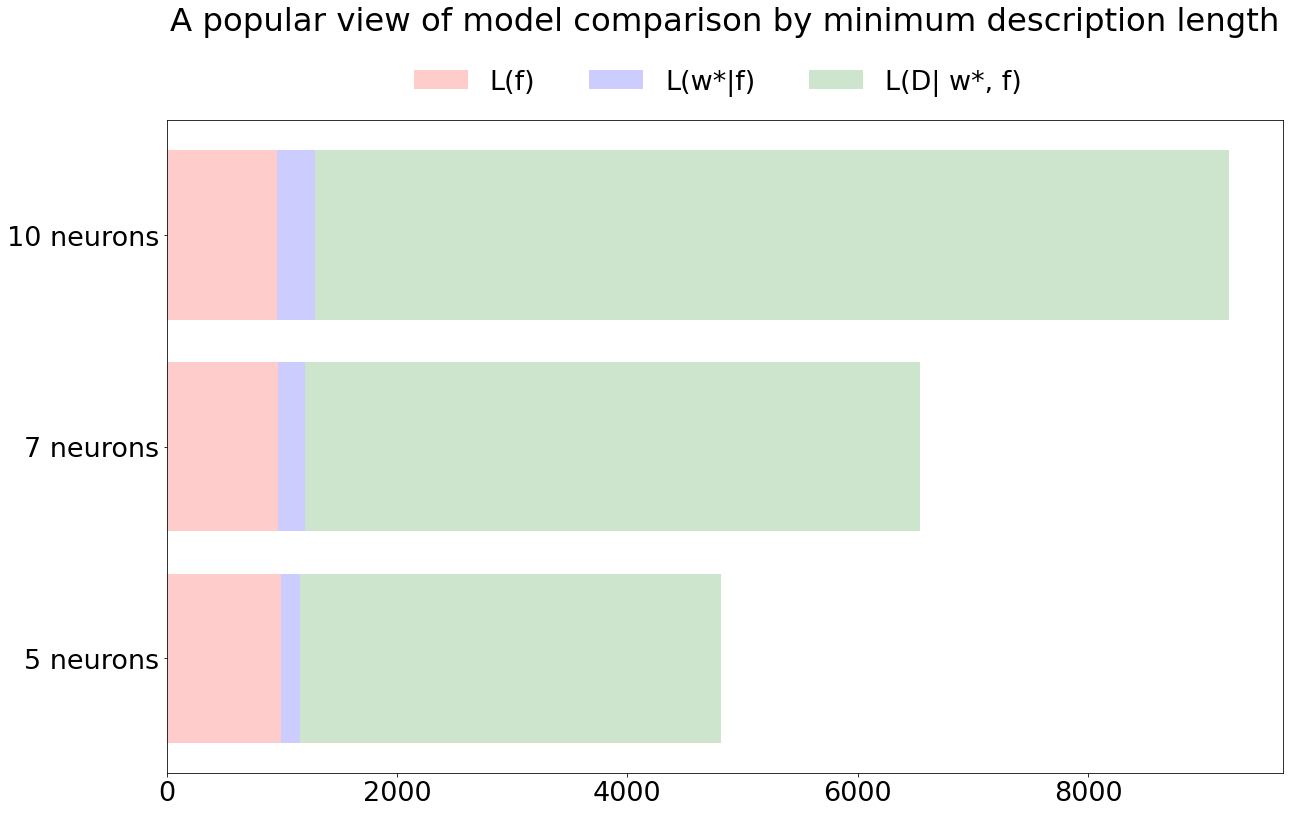

In [72]:

fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = 20, 12
plt.rcParams.update({'font.size': 27})

series = [[], [], []]
for case in [net, net2, net3]:
    l1, l2, l3 = find_mdl(case)
    #series.append([abs(l1), abs(l2) + abs(l1), abs(l2) + abs(l1)+ abs(l3)])
    series[0].append(abs(l1))
    series[1].append(abs(l2))
    series[2].append(abs(l3))

index = np.arange(3)
labels = ['L(f)', 'L(w*|f)', 'L(D| w*, f)']
plt.title('A popular view of model comparison by minimum description length',  y=1.0, pad=90)
ax.barh(index,series[0],color='r', alpha = 0.2, label ='l')
ax.barh(index,series[1],color='b',left=series[0], alpha = 0.2, label ='l2')
ax.barh(index,series[2],color='g',left=np.sum([series[0],series[1]], axis = 0), alpha = 0.2, label ='l3')
plt.legend(labels, bbox_to_anchor=([0.2, 1, 0.6, 0]), ncol=4, frameon=False)
plt.yticks(index,['5 neurons','7 neurons','10 neurons'])
plt.show()






Когда мы переходим к более сложным моделям, длина описания параметров увеличивается. Но с другой стороны, длина
описания данных должна уменьшаться, потому что сложная модель способна уместить данные лучше. Тут этого не видно, возможно нужны более сложные модели. 